In [1]:
import os
import math
import random
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

img_path: data/images/boxer_36.jpg
mask_path: data/annotations/trimaps/boxer_36.png
[1 2 3]


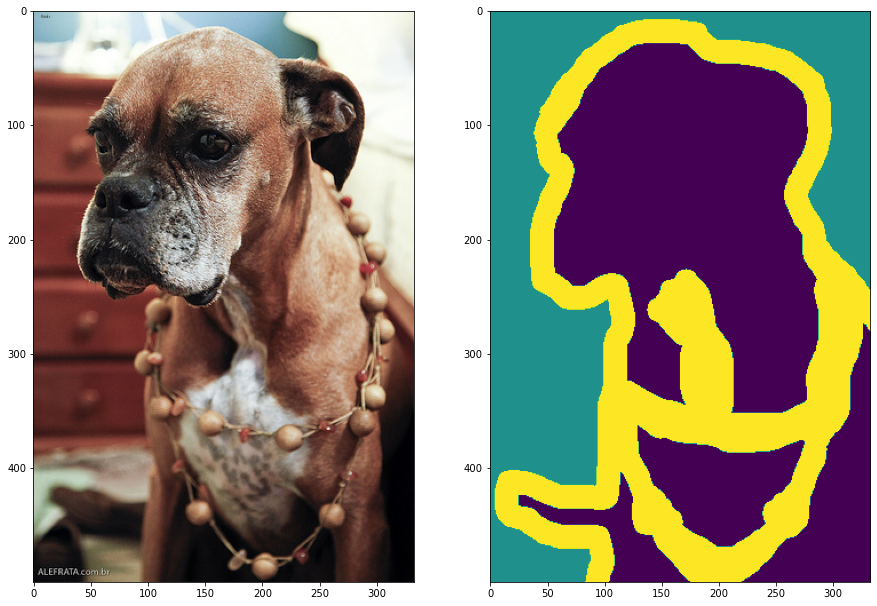

In [2]:
csv_path = 'data/kfolds.csv'
df = pd.read_csv(csv_path)
idx = random.choice(range(len(df)))

file_name = df.loc[idx].file_name
img_path = f'data/images/{file_name}.jpg'
mask_path = f'data/annotations/trimaps/{file_name}.png'

print('img_path:', img_path)
print('mask_path:', mask_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
print(np.unique(mask))
assert img.shape[:2] == mask.shape[:2]

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [3]:
from tensorflow import keras
import albumentations as A
import cv2

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            # Declare an augmentation pipeline
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15,
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask
        
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.fold = fold
        self.shuffle = shuffle
        self.mode = mode
        self.batch_size = batch_size
        self.image_size = image_size
        
        self.df = pd.read_csv(csv_path)
        if self.mode == 'train':    
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
    
        for _, r in data.iterrows():
            file_name = r['file_name']

            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            mask = cv2.imread(f'data/annotations/trimaps/{file_name}.png',
                              cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            #mask[mask != 1] = 0 #그대로 클래스를 사용하면 됨
            mask -= 1 # 0부터 클래스가 시작해야 하기 때문에 
            
            if self.mode == 'train':
                #image = image.astype('uint8')
                image, mask = self.transform(image=image, mask=mask)
                
            image = image.astype('float32')
            image = image / 255.
            mask = mask.astype('float32')

            batch_x.append(image)
            batch_y.append(mask)
        
        return batch_x, batch_y
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)

In [5]:
# https://github.com/karolzak/keras-unet
from keras_unet.models import custom_unet
from tensorflow.keras import optimizers

model = custom_unet(
    input_shape=(128, 128, 3),
    use_batch_norm=True,
    num_classes=3,
    filters=64,
    dropout=0.2,
    use_attention=True,
    output_activation='softmax')#sigmoid가 아닌 softmax로

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (Spati

In [6]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    verbose=1
)

Epoch 1/20
46/46 [==============================] - 66s 1s/step - loss: 0.8155 - val_loss: 11.2899
Epoch 2/20
46/46 [==============================] - 58s 1s/step - loss: 0.5699 - val_loss: 3.0654
Epoch 3/20
46/46 [==============================] - 57s 1s/step - loss: 0.4840 - val_loss: 1.3419
Epoch 4/20
46/46 [==============================] - 57s 1s/step - loss: 0.4338 - val_loss: 0.6351
Epoch 5/20
46/46 [==============================] - 57s 1s/step - loss: 0.4059 - val_loss: 0.5912
Epoch 6/20
46/46 [==============================] - 58s 1s/step - loss: 0.3838 - val_loss: 0.4831
Epoch 7/20
46/46 [==============================] - 61s 1s/step - loss: 0.3687 - val_loss: 0.4915
Epoch 8/20
46/46 [==============================] - 60s 1s/step - loss: 0.3530 - val_loss: 0.3927
Epoch 9/20
46/46 [==============================] - 65s 1s/step - loss: 0.3427 - val_loss: 0.3881
Epoch 10/20
46/46 [==============================] - 62s 1s/step - loss: 0.3296 - val_loss: 0.3635
Epoch 11/20
46/46 

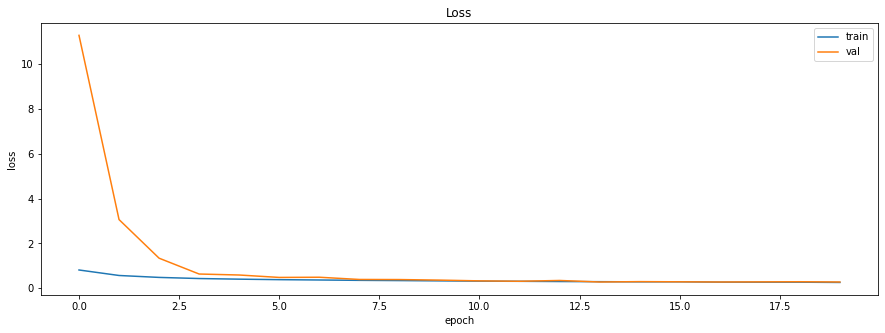

In [7]:
import matplotlib.pyplot as plt
history = history.history
plt.figure(figsize=(15, 5))
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")
plt.show()

In [8]:
for images, masks in valid_generator:
    break
preds = model.predict(images)

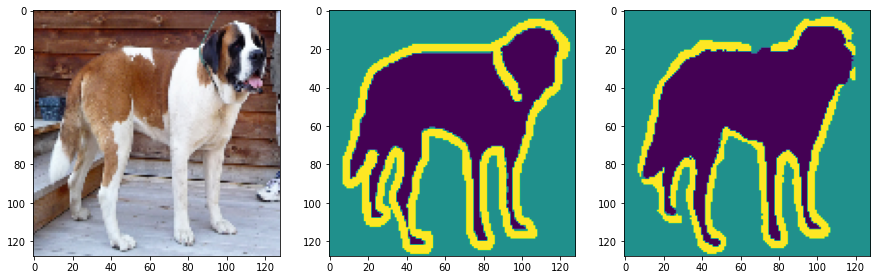

In [19]:
import random
idx = random.choice(range(len(preds)))
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(images[idx, ...])
plt.subplot(1, 3, 2)
plt.imshow(masks[idx])
plt.subplot(1, 3, 3)
pred = np.argmax(preds[idx], axis=-1)#확률이 가장 높은 값 하나만 남기고 나머지는 버린다
plt.imshow(pred)

In [12]:
np.unique(pred)

array([0, 1, 2])